# Loading Packages & Libraries

In [ ]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning, module="statsmodels")

import pmdarima as pm

In [ ]:
df = pd.read_excel("/content/HS861M 2010-.xlsx", sheet_name=0)
df.head()

,Year,Month,State,Data Status,Residential Revenue,Residential Sales,Residential Customers,Residential Price,Commercial Revenue,Commercial Sales,...,Industrial Customers,Industrial Price,Transportation Revenue,Transportation Sales,Transportation Customers,Transportation Price,Total Revenue,Total Sales,Total Customers,Total Price
0,2024,8.0,AK,Preliminary,41455.79,147071.1,300921.0,28.19,54151.16,213280.75,...,1227.0,20.47,0.00,0.00,0.0,0.00,119020.26,474728.62,359966.0,25.07
1,2024,8.0,AL,Preliminary,544246.42,3659605.8,2410796.0,14.87,317586.85,2370372.90,...,7245.0,7.29,0.00,0.00,0.0,0.00,1071200.10,8900082.90,2806041.0,12.04
2,2024,8.0,AR,Preliminary,253567.70,2032838.5,1488194.0,12.47,123643.54,1226540.50,...,41846.0,6.95,3.77,27.62,2.0,13.63,505260.10,5102315.30,1739731.0,9.90
3,2024,8.0,AZ,Preliminary,784064.00,5278946.4,3103761.0,14.85,486932.56,3822927.50,...,7080.0,9.24,109.80,959.96,2.0,11.44,1385900.70,10344991.00,3457837.0,13.40
4,2024,8.0,CA,Preliminary,3125289.80,10064788.0,14325972.0,31.05,3196792.20,11053106.00,...,150875.0,24.93,10544.65,60920.46,13.0,17.31,7415250.00,25520629.00,16270648.0,29.06


# Cleaning the Data

In [ ]:
# ensuring consistency in column names
df.columns = df.columns.str.lower()
df.columns = df.columns.str.replace(" ", "_")

In [ ]:
# checking dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8977 entries, 0 to 8976
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   year                      8977 non-null   object 
 1   month                     8976 non-null   float64
 2   state                     8976 non-null   object 
 3   data_status               8976 non-null   object 
 4   residential_revenue       8976 non-null   float64
 5   residential_sales         8976 non-null   float64
 6   residential_customers     8976 non-null   float64
 7   residential_price         8976 non-null   float64
 8   commercial_revenue        8976 non-null   float64
 9   commercial_sales          8976 non-null   float64
 10  commercial_customers      8976 non-null   float64
 11  commercial_price          8976 non-null   float64
 12  industrial_revenue        8976 non-null   float64
 13  industrial_sales          8976 non-null   float64
 14  industri

In [ ]:
df["year"].unique()

array([2024, 2023, 2022, 2021, 2020, 2019, 2018, 2017, 2016, 2015, 2014,
       2013, 2012, 2011, 2010,
       'For October and November 2017, Puerto Rico Electric Power Authority supplied their data in the aggregate and EIA estimated the sector breakdowns.\nThe sector, Other, was collected from 1990-2002 and the Transportation sector has been collected since 2003.\nCustomer counts started to be published in 2007.\nEIA started collecting data from Puerto Rico in June 2014.'],
      dtype=object)

In [ ]:
data_monthly_states_cleaned = df[pd.to_numeric(df['year'], errors='coerce').notnull()]
data_monthly_states_cleaned = data_monthly_states_cleaned[pd.to_numeric(data_monthly_states_cleaned['month'], errors='coerce').notnull()]

data_monthly_states_cleaned['year'] = data_monthly_states_cleaned['year'].astype(int)
data_monthly_states_cleaned['month'] = data_monthly_states_cleaned['month'].astype(int)

data_monthly_states_cleaned['date'] = pd.to_datetime(data_monthly_states_cleaned[['year', 'month']].assign(DAY=1))
df = data_monthly_states_cleaned.copy()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8976 entries, 0 to 8975
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   year                      8976 non-null   int64         
 1   month                     8976 non-null   int64         
 2   state                     8976 non-null   object        
 3   data_status               8976 non-null   object        
 4   residential_revenue       8976 non-null   float64       
 5   residential_sales         8976 non-null   float64       
 6   residential_customers     8976 non-null   float64       
 7   residential_price         8976 non-null   float64       
 8   commercial_revenue        8976 non-null   float64       
 9   commercial_sales          8976 non-null   float64       
 10  commercial_customers      8976 non-null   float64       
 11  commercial_price          8976 non-null   float64       
 12  industrial_revenue       

In [ ]:
df["year"].unique()

array([2024, 2023, 2022, 2021, 2020, 2019, 2018, 2017, 2016, 2015, 2014,
       2013, 2012, 2011, 2010])

In [ ]:
df["month"].unique()

array([ 8,  7,  6,  5,  4,  3,  2,  1, 12, 11, 10,  9])

In [ ]:
df["date"].unique()

<DatetimeArray>
['2024-08-01 00:00:00', '2024-07-01 00:00:00', '2024-06-01 00:00:00',
 '2024-05-01 00:00:00', '2024-04-01 00:00:00', '2024-03-01 00:00:00',
 '2024-02-01 00:00:00', '2024-01-01 00:00:00', '2023-12-01 00:00:00',
 '2023-11-01 00:00:00',
 ...
 '2010-10-01 00:00:00', '2010-09-01 00:00:00', '2010-08-01 00:00:00',
 '2010-07-01 00:00:00', '2010-06-01 00:00:00', '2010-05-01 00:00:00',
 '2010-04-01 00:00:00', '2010-03-01 00:00:00', '2010-02-01 00:00:00',
 '2010-01-01 00:00:00']
Length: 176, dtype: datetime64[ns]

In [ ]:
# checking for missing values

for column in df.columns:
    null_count = df[column].isnull().sum()
    if null_count > 0:
        print(f"{column}: {null_count} null values")

print("Missing value check completed.")

Missing value check completed.


In [ ]:
# checking for duplicated rows

if df.duplicated().any():
    print("There are duplicated rows in the dataframe.")
    print(f"Number of duplicated rows: {df.duplicated().sum()}")
else:
    print("There are no duplicated rows in the dataframe.")

There are no duplicated rows in the dataframe.


In [ ]:
# checking for negative values

for column in df.columns:
    if df[column].dtype in ["int64", "float64"]:
        negative_count = (df[column] < 0).sum()
        if negative_count > 0:
            print(f"{column}: {negative_count} negative values")

transportation_revenue: 2 negative values


In [ ]:
# while these values are possible
# might cause issues later
# something to keep in mind

df[df['transportation_revenue'] < 0]

,year,month,state,data_status,residential_revenue,residential_sales,residential_customers,residential_price,commercial_revenue,commercial_sales,...,industrial_price,transportation_revenue,transportation_sales,transportation_customers,transportation_price,total_revenue,total_sales,total_customers,total_price,date
1537,2022,2,DC,Final,28798.10,214524.34,302664.0,13.42,82440.97,558081.48,...,8.60,-0.01,19907.24,3.0,0.0,112394.27,805940.12,329603.0,13.95,2022-02-01
6127,2014,8,DC,Final,24163.18,191601.81,237673.0,12.61,86404.48,755884.71,...,7.86,-0.01,29184.29,1.0,0.0,111938.33,994102.81,264050.0,11.26,2014-08-01


In [ ]:
df[["transportation_revenue", "transportation_sales", "transportation_customers", "transportation_price"]].describe()

,transportation_revenue,transportation_sales,transportation_customers,transportation_price
count,8976.000000,8976.000000,8976.000000,8976.000000
mean,1249.755334,11931.855285,1.825869,5.554482
std,4411.004507,34580.214248,3.646295,5.361677
min,-0.010000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,43.000000,500.330000,1.000000,6.950000
75%,643.422500,7135.597500,2.000000,9.660000
max,52880.050000,341166.420000,58.000000,43.280000


# Time Series Forecasting

## Functions

### Function: Checking Stationarity

In [ ]:
def plot_time_series(data, column, title="Time Series Analysis", window=12):
    plt.figure(figsize=(12, 6))
    plt.plot(data[column], label="Original", color="blue")
    plt.plot(data[column].rolling(window).mean(), label="Moving Mean", color="red", linestyle="--")
    plt.plot(data[column].rolling(window).std(), label="Moving Std Dev", color="green", linestyle="--")
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Values")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [ ]:
def test_stationarity(data, column):
    adf_result = adfuller(data[column].dropna())
    adf_summary = {
        "Test Statistic": adf_result[0],
        "p-value": adf_result[1],
        "Lags Used": adf_result[2],
        "Observations": adf_result[3]
    }

    print("Augmented Dickey-Fuller Test Results:")
    for key, value in adf_summary.items():
        print(f"{key}: {value}")

    if adf_summary["p-value"] < 0.05:
        print("\nConclusion: Time series is stationary.")
    else:
        print("\nConclusion: Time series is non-stationary.")


    kpss_result = kpss(data[column].dropna(), nlags='auto')
    kpss_summary = {
        "Test Statistic": kpss_result[0],
        "p-value": kpss_result[1],
        "Lags Used": kpss_result[2],
        "Critical Values": kpss_result[3]
    }

    print("\nKPSS Test Results:")
    for key, value in kpss_summary.items():
        print(f"{key}: {value}")

    if kpss_summary["p-value"] > 0.05:
        print("\nKPSS Conclusion: Time series is stationary.")
    else:
        print("\nKPSS Conclusion: Time series is non-stationary (variance).")

### Function: ACF, PACF

In [ ]:
def plot_acf_pacf(data, lags=40, title="Time Series Analysis"):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(title, fontsize=16)

    plot_acf(data, lags=lags, ax=ax[0], title="Autocorrelation (ACF)")
    ax[0].grid()

    plot_pacf(data, lags=lags, ax=ax[1], method='ywm', title="Partial Autocorrelation (PACF)")
    ax[1].grid()

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

### Function: Seasonal Differencing

In [ ]:
def seasonal_difference(series, period=6):
    differenced_series = pd.DataFrame(series - series.shift(period))
    return differenced_series.dropna()

### Function: Evaluate Model

In [ ]:
def evaluate_model(test_data, predictions):
    rmse = np.sqrt(mean_squared_error(test_data, predictions))
    mae = mean_absolute_error(test_data, predictions)
    r2 = r2_score(test_data, predictions)
    return rmse, mae, r2

### Function: Time Series (Auto Arima)

In [ ]:
def optimize_arima_sarima(train_data, test_data, p_range, d_range, q_range, seasonal=False, seasonal_period=None, seasonal_params=None, future_period=12):
    results = {}

    start_p, max_p = p_range[0], p_range[1]
    start_d, max_d = d_range[0], d_range[1]
    start_q, max_q = q_range[0], q_range[1]

    if seasonal_params is not None:
        start_P, max_P = seasonal_params['P'][0], seasonal_params['P'][1]
        start_D, max_D = seasonal_params['D'][0], seasonal_params['D'][1]
        start_Q, max_Q = seasonal_params['Q'][0], seasonal_params['Q'][1]
        seasonal_S = seasonal_params['S']


    print("\nFitting ARIMA Model ...")

    best_arima_model = pm.auto_arima(
        train_data, seasonal=False, m=1,
        start_p=start_p, max_p=max_p,
        start_d=start_d, max_d=max_d,
        start_q=start_q, max_q=max_q,
        stepwise=True, trace=False
    )

    # arima_forecast = best_arima_model.predict(n_periods=len(test_data))
    arima_forecast, arima_conf_int = best_arima_model.predict(
        n_periods=len(test_data) + future_period, return_conf_int=True
    )
    arima_rmse, arima_mae, arima_r2 = evaluate_model(test_data, arima_forecast[:len(test_data)])

    results["ARIMA"] = {
        "RMSE": arima_rmse,
        "MAE": arima_mae,
        "R2": arima_r2
    }

    print("ARIMA model fitted ...")

    if seasonal:

        print("\nFitting SARIMA model ...")

        best_sarima_model = pm.auto_arima(
            train_data, seasonal=True, m=seasonal_S,
            start_p=start_p, max_p=max_p,
            start_d=start_d, max_d=max_d,
            start_q=start_q, max_q=max_q,
            start_P=start_P, max_P=max_P,
            start_D=start_D, max_D=max_D,
            start_Q=start_Q, max_Q=max_Q,
            stepwise=True, trace=False
        )

        # sarima_forecast = best_sarima_model.predict(n_periods=len(test_data))
        sarima_forecast, sarima_conf_int = best_sarima_model.predict(
            n_periods=len(test_data) + future_period, return_conf_int=True
        )
        sarima_rmse, sarima_mae, sarima_r2 = evaluate_model(test_data, sarima_forecast[:len(test_data)])

        results["SARIMA"] = {
            "RMSE": sarima_rmse,
            "MAE": sarima_mae,
            "R2": sarima_r2
        }

        print("SARIMA model fitted ...")

        return results, best_arima_model, arima_forecast, arima_conf_int, best_sarima_model, sarima_forecast, sarima_conf_int

    return results, best_arima_model, arima_forecast, arima_conf_int

### Function: Reverse Seasonal Differencing

In [ ]:
def reverse_seasonal_differencing(original_series, differenced_predictions, conf_int_lower, conf_int_upper, period):
    reversed_predictions = list(original_series[:period])
    reversed_lower = list(original_series[:period])
    reversed_upper = list(original_series[:period])

    for i in range(len(differenced_predictions)):
        seasonal_value = reversed_predictions[i]

        reversed_predictions.append(differenced_predictions[i] + seasonal_value)
        reversed_lower.append(conf_int_lower[i] + seasonal_value)
        reversed_upper.append(conf_int_upper[i] + seasonal_value)

    return (
        np.array(reversed_predictions),
        np.array(reversed_lower),
        np.array(reversed_upper)
    )

### Function: Final Plotting

In [ ]:
def plot_results(state_data, sector, actual_values, reversed_predictions, lower_conf_int, upper_conf_int, train_data, test_data, future_period):
    original_index = state_data[sector].index
    freq = pd.infer_freq(original_index)
    extended_index = pd.date_range(
        start=original_index[0],
        periods=len(original_index) + future_period,
        freq=freq
    )

    plt.figure(figsize=(12, 6))

    # plotting true values
    plt.plot(
        state_data[sector].index[:-len(test_data)],
        actual_values[:-len(test_data)],
        label="Actual Values",
        color="green",
        linewidth=1
    )

    plt.plot(
        state_data[sector].index,
        actual_values,
        color="green",
        linestyle="--",
        linewidth=1
    )

    # plotting predictions
    plt.plot(
        extended_index[-(len(test_data) + future_period):],
        reversed_predictions[-(len(test_data) + future_period):],
        label="Predictions",
        color="red",
        linewidth=1
    )

    # plotting confidence intervals
    plt.fill_between(
        extended_index[-(len(test_data) + future_period):],
        lower_conf_int[-(len(test_data) + future_period):],
        upper_conf_int[-(len(test_data) + future_period):],
        color="orange",
        alpha=0.2,
        label="95% Confidence Interval"
    )

    plt.xlabel("Time")
    plt.ylabel("Sales")
    plt.title("Time Series Forecast")
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.grid()
    plt.show()

### Function: Adjust Bias

In [ ]:
def adjust_bias(test_data, forecast, lower_conf_int, upper_conf_int):
    residuals = test_data.values - forecast.values[:len(test_data)]
    bias_correction = residuals.mean()
    adjusted_predictions = forecast + bias_correction
    adjusted_lower_conf_int = lower_conf_int + bias_correction
    adjusted_upper_conf_int = upper_conf_int + bias_correction
    return adjusted_predictions, adjusted_lower_conf_int, adjusted_upper_conf_int

## Analyses

### Analysis: Michigan (Residential Sector)

In [ ]:
residential = "residential_sales"
mi_residential = df[df["state"] == "MI"]

mi_residential.set_index("date", inplace=True)
mi_residential = mi_residential.sort_index(ascending=True)

In [ ]:
mi_residential

,year,month,state,data_status,residential_revenue,residential_sales,residential_customers,residential_price,commercial_revenue,commercial_sales,...,industrial_customers,industrial_price,transportation_revenue,transportation_sales,transportation_customers,transportation_price,total_revenue,total_sales,total_customers,total_price
date,,,,,,,,,,,,,,,,,,,,,
2010-01-01,2010,1,MI,Final,374780.00,3281757.0,4247771.0,11.42,298599.00,3240851.0,...,12147.0,6.99,42.00,373.00,1.0,11.26,834925.0,8832476.0,4781495.0,9.45
2010-02-01,2010,2,MI,Final,312020.00,2697612.0,4247542.0,11.57,273810.00,2896480.0,...,12338.0,6.79,45.00,394.00,1.0,11.42,750838.0,8025787.0,4782728.0,9.36
2010-03-01,2010,3,MI,Final,320550.00,2712814.0,4247590.0,11.82,286711.00,2973960.0,...,13345.0,6.41,47.00,443.00,1.0,10.61,767317.0,8184398.0,4784419.0,9.38
2010-04-01,2010,4,MI,Final,280705.00,2203730.0,4246081.0,12.74,289985.00,2889711.0,...,12319.0,7.16,42.00,392.00,1.0,10.71,745976.0,7541365.0,4781331.0,9.89
2010-05-01,2010,5,MI,Final,326415.00,2549112.0,4245366.0,12.81,323912.00,3144752.0,...,12251.0,7.29,49.00,432.00,1.0,11.34,845397.0,8370852.0,4780847.0,10.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-01,2024,4,MI,Preliminary,432970.35,2251208.2,4529699.0,19.23,400723.10,2827688.4,...,5684.0,8.20,67.35,473.47,2.0,14.22,1024599.9,7406823.9,5098942.0,13.83
2024-05-01,2024,5,MI,Preliminary,481535.21,2477254.7,4531883.0,19.44,449325.16,3123397.1,...,5683.0,8.67,65.47,447.64,2.0,14.62,1135691.7,7963840.3,5102137.0,14.26
2024-06-01,2024,6,MI,Preliminary,629389.85,3165403.3,4530758.0,19.88,481623.42,3315461.2,...,5632.0,8.51,66.51,477.43,2.0,13.93,1310928.9,8829107.7,5100783.0,14.85


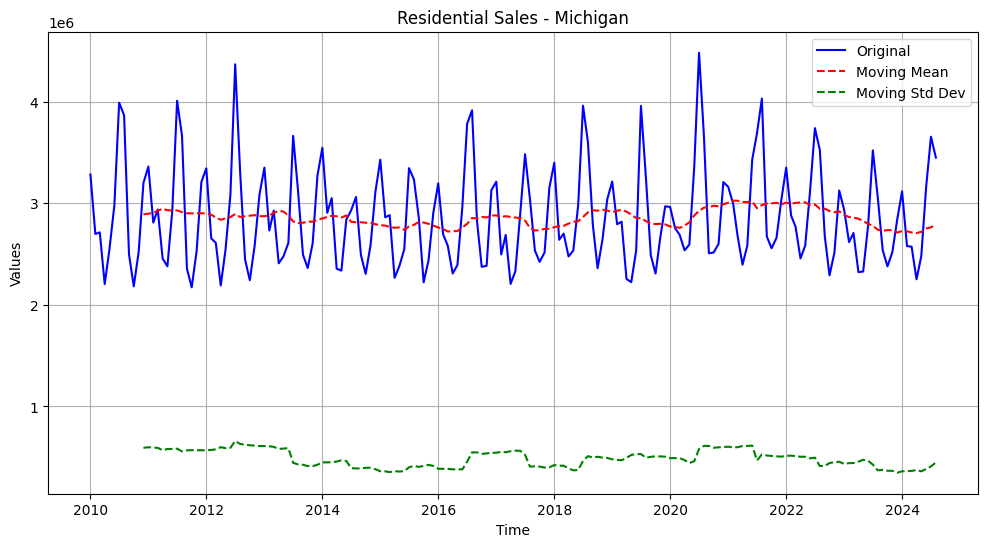

In [ ]:
plot_time_series(mi_residential, column=residential, title="Residential Sales - Michigan")

In [ ]:
test_stationarity(mi_residential, column=residential)

Augmented Dickey-Fuller Test Results:
Test Statistic: -3.1268378565240904
p-value: 0.024629772398531855
Lags Used: 13
Observations: 162

Conclusion: Time series is stationary.

KPSS Test Results:
Test Statistic: 0.15943920014340676
p-value: 0.1
Lags Used: 70
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

KPSS Conclusion: Time series is stationary.


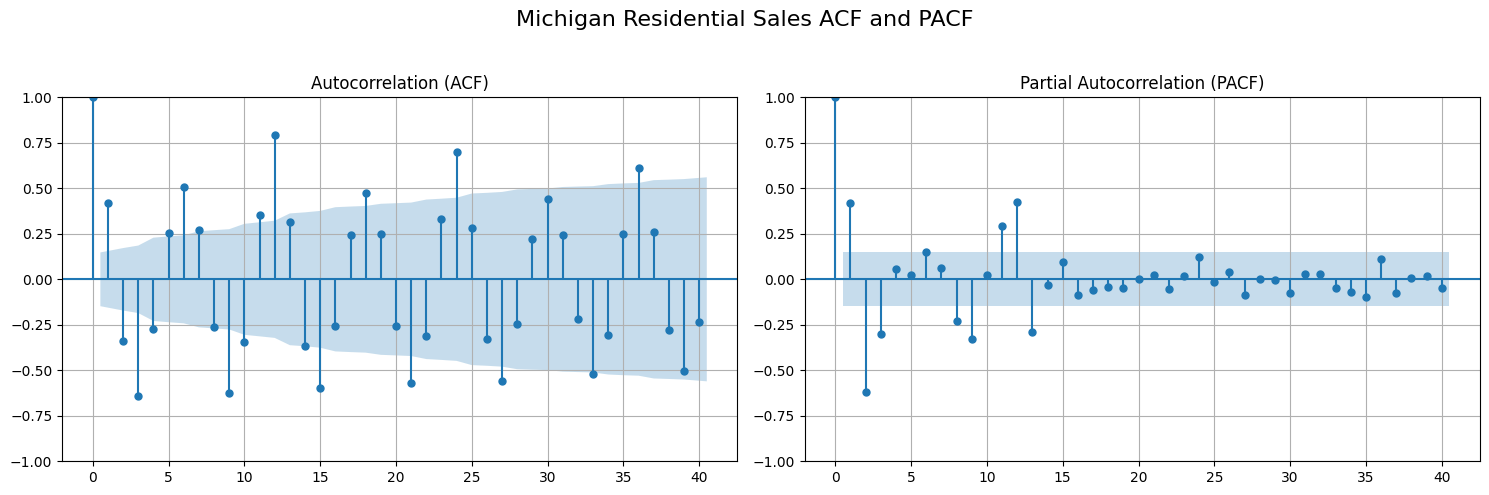

In [ ]:
plot_acf_pacf(mi_residential[residential], lags=40, title="Michigan Residential Sales ACF and PACF")

There seems to be a seasonlity of 6 months as can be seen from the repeating sinusoidal wave like patterns in the ACF plot. We should explore seasonality differencing.

In [ ]:
mi_seasonally_diff_residential = seasonal_difference(mi_residential[residential], period=6)

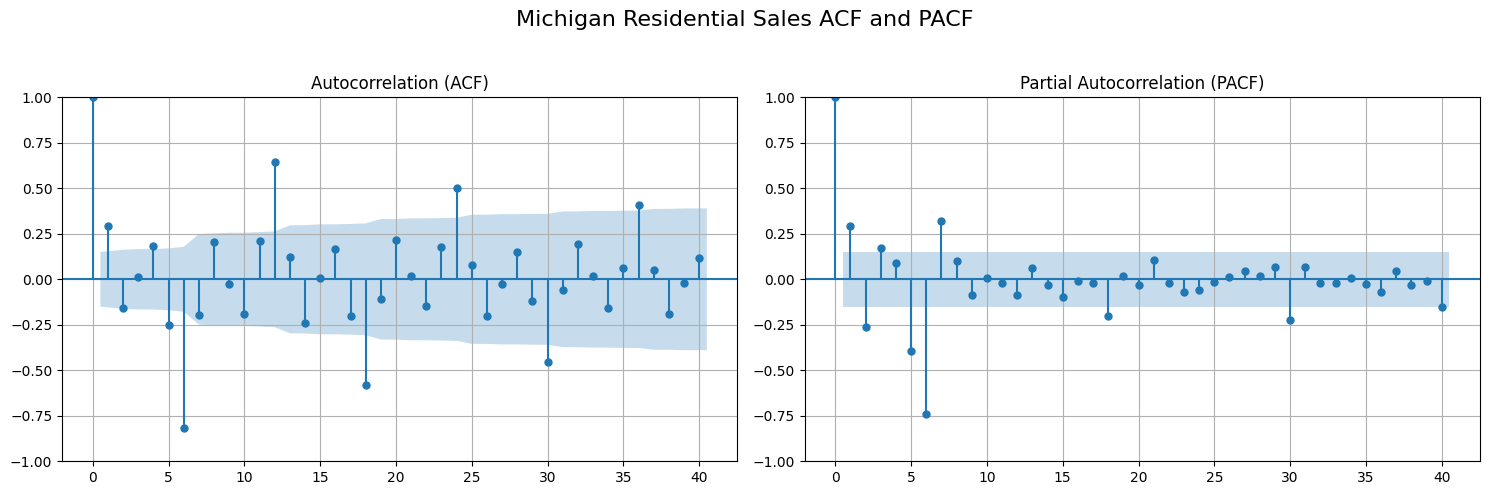

In [ ]:
plot_acf_pacf(mi_seasonally_diff_residential[residential], lags=40, title="Michigan Residential Sales ACF and PACF")

The sinusoidal wave like patterns have been removed. The data still has a seasonal component at every 12 lags (as seen by the spikes). This indicates that seasonal auto regression models might be more appropriate for this type of forecasting.

In [ ]:
train_size_residential = int(len(mi_seasonally_diff_residential) * 0.8)
train_data_residential = mi_seasonally_diff_residential.iloc[:train_size_residential][residential]
test_data_residential = mi_seasonally_diff_residential.iloc[train_size_residential:][residential]

train_data_residential = train_data_residential.asfreq("MS")
test_data_residential = test_data_residential.asfreq("MS")

In [ ]:
p_range = (0, 7)
d_range = (0, 1)
q_range = (0, 6)

seasonal_params = {
    'P': (0, 2),
    'D': (0, 1),
    'Q': (0, 2),
    'S': 12
}

In [ ]:
results_residential, best_arima_model_residential, arima_forecast_residential, arima_conf_int_residential, best_sarima_model_residential, sarima_forecast_residential, sarima_conf_int_residential = optimize_arima_sarima(
    train_data_residential, test_data_residential, p_range, d_range, q_range, True, seasonal_period=12, seasonal_params=seasonal_params)


Fitting ARIMA Model ...
ARIMA model fitted ...

Fitting SARIMA model ...
SARIMA model fitted ...


In [ ]:
results_residential

{'ARIMA': {'RMSE': 209445.69131485897,
  'MAE': 151761.24298036448,
  'R2': 0.7510585601088172},
 'SARIMA': {'RMSE': 214253.620415312,
  'MAE': 158333.42783899535,
  'R2': 0.7394982322966017}}

In [ ]:
mi_residential[residential].describe()

,residential_sales
count,1.760000e+02
mean,2.861077e+06
std,4.831624e+05
min,2.171967e+06
25%,2.504298e+06
50%,2.722040e+06
75%,3.152791e+06
max,4.480768e+06


In [ ]:
best_arima_model_residential

ARIMA(order=(6, 0, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [ ]:
best_sarima_model_residential

ARIMA(order=(3, 0, 0), scoring_args={}, seasonal_order=(2, 0, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [ ]:
reversed_predictions_residential, lower_conf_int_residential, upper_conf_int_residential = reverse_seasonal_differencing(
    original_series=mi_residential[residential].values,
    differenced_predictions=np.concatenate([train_data_residential, arima_forecast_residential]),
    conf_int_lower=np.concatenate([train_data_residential, arima_conf_int_residential[:, 0]]),
    conf_int_upper=np.concatenate([train_data_residential, arima_conf_int_residential[:, 1]]),
    period=6
)

In [ ]:
actual_values_residential = mi_residential[residential].values

In [ ]:
print(f"Length of original series = {len(actual_values_residential)}")
print(f"Length of series w/ predictions = {len(reversed_predictions_residential)}")
print(f"Length of series w/ lower confidence interval = {len(lower_conf_int_residential)}")
print(f"Length of series w/ upper confidence interval = {len(upper_conf_int_residential)}")

Length of original series = 176
Length of series w/ predictions = 188
Length of series w/ lower confidence interval = 188
Length of series w/ upper confidence interval = 188


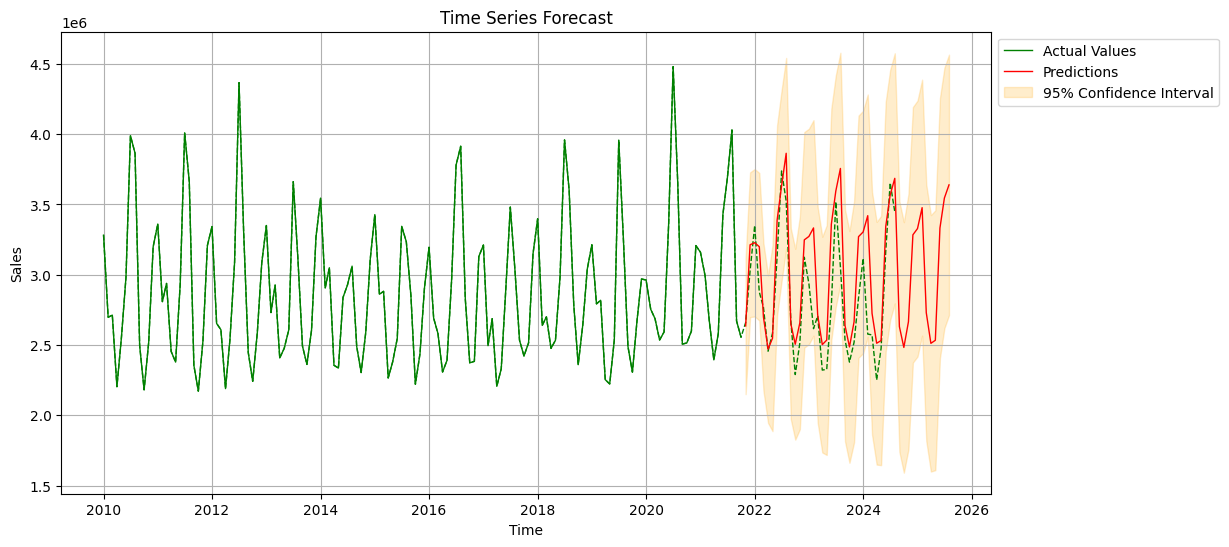

In [ ]:
plot_results(mi_residential, residential, actual_values_residential, reversed_predictions_residential, lower_conf_int_residential, upper_conf_int_residential, train_data_residential, test_data_residential, future_period=12)

**Analysis of Michigan's Residential Sector:** <br>
The time series for Michigan's residential energy sector was stationary, as determined by examining the rolling mean, standard deviation, and confirming with both ADF and KPSS tests. Analyzing the autocorrelation function (ACF) plot revealed a strong seasonal component with a frequency of six, indicative of a repeating biannual pattern. Seasonal differencing with a period of six was applied to address this seasonality, effectively removing the wave-like patterns in the data.

The ARIMA model (6, 0, 2)(0, 0, 0)[0] performed best for this sector, achieving a root mean square error (RMSE) of 209,445, a mean absolute error (MAE) of 151,761, and an R² of 0.75. Compared to the target column's standard deviation of 483,162, this represents a significant improvement. Predictions for the test data closely aligned with the true values, demonstrating the model’s ability to capture seasonal fluctuations effectively.

The future forecast highlights a predictable seasonal pattern, with energy consumption showing periodic drops and rises. A seasonal dip is projected towards the end of the year, followed by a rise at the beginning of the next, continuing in a similar cyclical manner. Interestingly, the peak levels of consumption appear to be gradually declining over time. This insight could guide energy production and storage strategies, such as allocating resources during peak usage times while optimizing storage during periods of low demand.

### Analysis: Michigan (Commercial Sector)

In [ ]:
commercial = "commercial_sales"
mi_commercial = df[df["state"] == "MI"]

mi_commercial.set_index("date", inplace=True)
mi_commercial = mi_commercial.sort_index(ascending=True)

In [ ]:
mi_commercial

,year,month,state,data_status,residential_revenue,residential_sales,residential_customers,residential_price,commercial_revenue,commercial_sales,...,industrial_customers,industrial_price,transportation_revenue,transportation_sales,transportation_customers,transportation_price,total_revenue,total_sales,total_customers,total_price
date,,,,,,,,,,,,,,,,,,,,,
2010-01-01,2010,1,MI,Final,374780.00,3281757.0,4247771.0,11.42,298599.00,3240851.0,...,12147.0,6.99,42.00,373.00,1.0,11.26,834925.0,8832476.0,4781495.0,9.45
2010-02-01,2010,2,MI,Final,312020.00,2697612.0,4247542.0,11.57,273810.00,2896480.0,...,12338.0,6.79,45.00,394.00,1.0,11.42,750838.0,8025787.0,4782728.0,9.36
2010-03-01,2010,3,MI,Final,320550.00,2712814.0,4247590.0,11.82,286711.00,2973960.0,...,13345.0,6.41,47.00,443.00,1.0,10.61,767317.0,8184398.0,4784419.0,9.38
2010-04-01,2010,4,MI,Final,280705.00,2203730.0,4246081.0,12.74,289985.00,2889711.0,...,12319.0,7.16,42.00,392.00,1.0,10.71,745976.0,7541365.0,4781331.0,9.89
2010-05-01,2010,5,MI,Final,326415.00,2549112.0,4245366.0,12.81,323912.00,3144752.0,...,12251.0,7.29,49.00,432.00,1.0,11.34,845397.0,8370852.0,4780847.0,10.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-01,2024,4,MI,Preliminary,432970.35,2251208.2,4529699.0,19.23,400723.10,2827688.4,...,5684.0,8.20,67.35,473.47,2.0,14.22,1024599.9,7406823.9,5098942.0,13.83
2024-05-01,2024,5,MI,Preliminary,481535.21,2477254.7,4531883.0,19.44,449325.16,3123397.1,...,5683.0,8.67,65.47,447.64,2.0,14.62,1135691.7,7963840.3,5102137.0,14.26
2024-06-01,2024,6,MI,Preliminary,629389.85,3165403.3,4530758.0,19.88,481623.42,3315461.2,...,5632.0,8.51,66.51,477.43,2.0,13.93,1310928.9,8829107.7,5100783.0,14.85


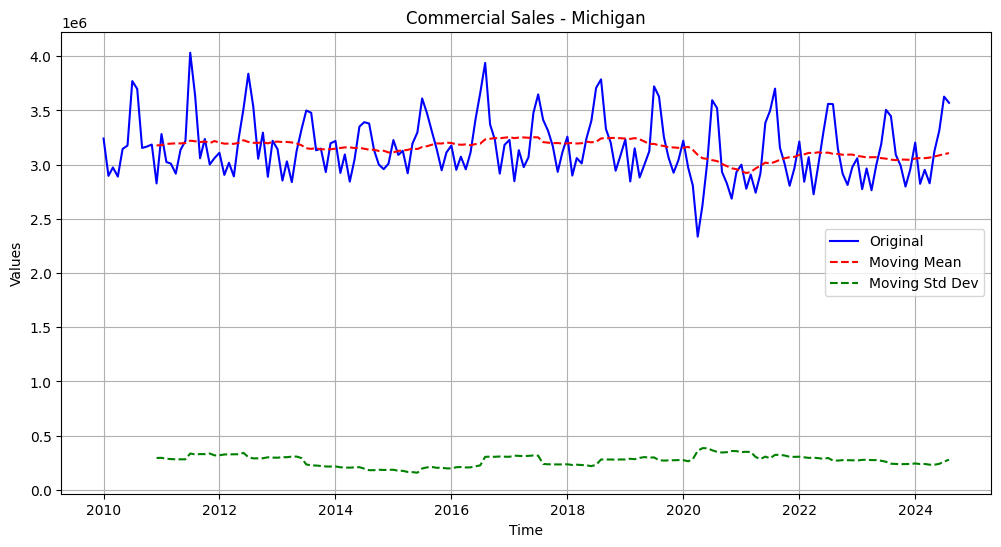

In [ ]:
plot_time_series(mi_commercial, column=commercial, title="Commercial Sales - Michigan")

In [ ]:
test_stationarity(mi_commercial, column=commercial)

Augmented Dickey-Fuller Test Results:
Test Statistic: -1.7612725321387668
p-value: 0.39985113597845856
Lags Used: 13
Observations: 162

Conclusion: Time series is non-stationary.

KPSS Test Results:
Test Statistic: 0.25349327139274996
p-value: 0.1
Lags Used: 2
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

KPSS Conclusion: Time series is stationary.


In [ ]:
mi_seasonally_diff_commercial = seasonal_difference(mi_commercial[commercial], period=1)

In [ ]:
test_stationarity(mi_seasonally_diff_commercial, column=commercial)

Augmented Dickey-Fuller Test Results:
Test Statistic: -7.556128581729134
p-value: 3.096143034389044e-11
Lags Used: 11
Observations: 163

Conclusion: Time series is stationary.

KPSS Test Results:
Test Statistic: 0.17905916233568261
p-value: 0.1
Lags Used: 24
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

KPSS Conclusion: Time series is stationary.


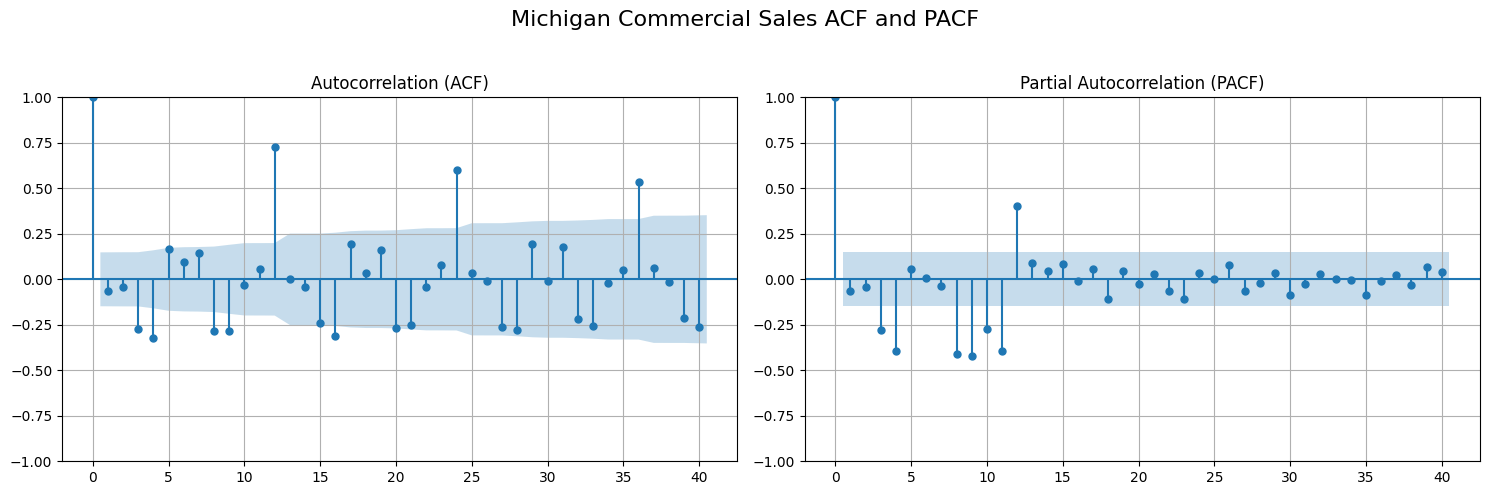

In [ ]:
plot_acf_pacf(mi_seasonally_diff_commercial[commercial], lags=40, title="Michigan Commercial Sales ACF and PACF")

There seems to be a seasonlity of 12 months as can be seen from the repeating spike patterns in the ACF plot. We should explore seasonality.

In [ ]:
# mi_seasonally_diff_commercial = seasonal_difference(mi_seasonally_diff_commercial[commercial], period=12)

In [ ]:
# plot_acf_pacf(mi_seasonally_diff_commercial[commercial], lags=40, title="Michigan Commercial Sales ACF and PACF")

In [ ]:
train_size_commercial = int(len(mi_seasonally_diff_commercial) * 0.8)
train_data_commercial = mi_seasonally_diff_commercial.iloc[:train_size_commercial][commercial]
test_data_commercial = mi_seasonally_diff_commercial.iloc[train_size_commercial:][commercial]

train_data_commercial = train_data_commercial.asfreq("MS")
test_data_commercial = test_data_commercial.asfreq("MS")

In [ ]:
p_range = (0, 12)
d_range = (0, 1)
q_range = (0, 6)

seasonal_params = {
    'P': (0, 2),
    'D': (0, 1),
    'Q': (0, 2),
    'S': 12
}

In [ ]:
results_commercial, best_arima_model_commercial, arima_forecast_commercial, arima_conf_int_commercial, best_sarima_model_commercial, sarima_forecast_commercial, sarima_conf_int_commercial = optimize_arima_sarima(
    train_data_commercial, test_data_commercial, p_range, d_range, q_range, True, seasonal_period=12, seasonal_params=seasonal_params)


Fitting ARIMA Model ...
ARIMA model fitted ...

Fitting SARIMA model ...
SARIMA model fitted ...


In [ ]:
results_commercial

{'ARIMA': {'RMSE': 237066.88429633345,
  'MAE': 215524.88857142857,
  'R2': -0.002501515608499316},
 'SARIMA': {'RMSE': 98414.43513609904,
  'MAE': 80545.11328874396,
  'R2': 0.8272329720655784}}

In [ ]:
mi_commercial[commercial].describe()

,commercial_sales
count,1.760000e+02
mean,3.149299e+06
std,2.763846e+05
min,2.335886e+06
25%,2.952122e+06
50%,3.119712e+06
75%,3.293413e+06
max,4.032132e+06


In [ ]:
best_arima_model_commercial

ARIMA(order=(0, 0, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [ ]:
best_sarima_model_commercial

ARIMA(order=(3, 0, 5), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [ ]:
reversed_predictions_commercial, lower_conf_int_commercial, upper_conf_int_commercial = reverse_seasonal_differencing(
    original_series=mi_commercial[commercial].values,
    differenced_predictions=np.concatenate([train_data_commercial, sarima_forecast_commercial]),
    conf_int_lower=np.concatenate([train_data_commercial, sarima_conf_int_commercial[:, 0]]),
    conf_int_upper=np.concatenate([train_data_commercial, sarima_conf_int_commercial[:, 1]]),
    period=1
)

In [ ]:
actual_values_commercial = mi_commercial[commercial].values

In [ ]:
print(f"Length of original series = {len(actual_values_commercial)}")
print(f"Length of series w/ predictions = {len(reversed_predictions_commercial)}")
print(f"Length of series w/ lower confidence interval = {len(lower_conf_int_commercial)}")
print(f"Length of series w/ upper confidence interval = {len(upper_conf_int_commercial)}")

Length of original series = 176
Length of series w/ predictions = 188
Length of series w/ lower confidence interval = 188
Length of series w/ upper confidence interval = 188


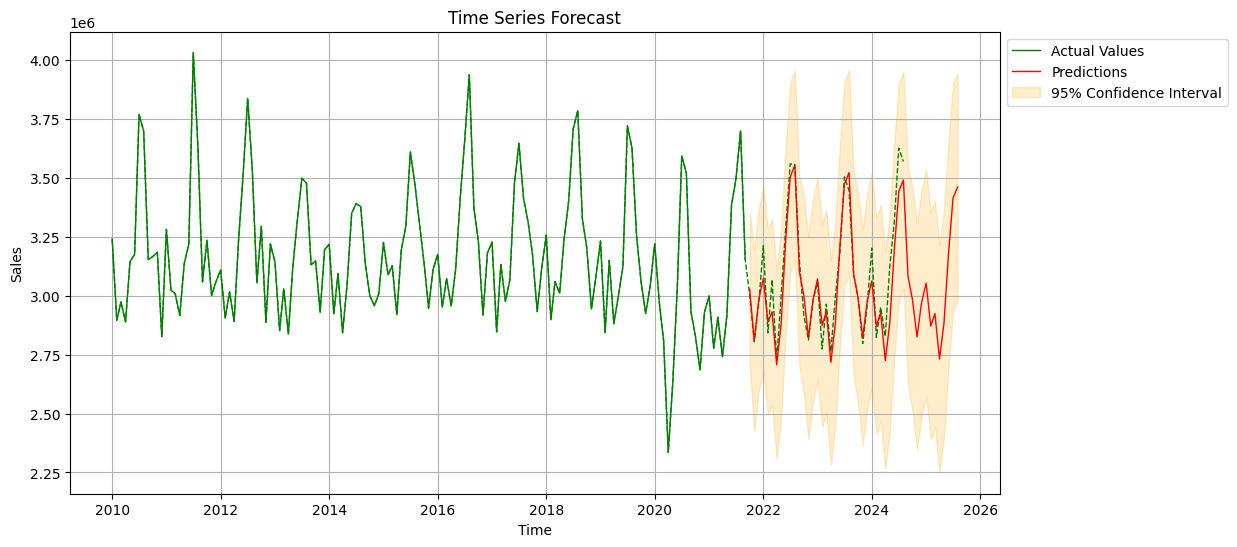

In [ ]:
plot_results(mi_commercial, commercial, actual_values_commercial, reversed_predictions_commercial, lower_conf_int_commercial, upper_conf_int_commercial, train_data_commercial, test_data_commercial, future_period=12)

**Analysis of Michigan's Commercial Sector:** <br>
The commercial sector's energy time series was initially non-stationary, as determined by the ADF test, but was stabilized after first-order differencing. The ACF plot revealed a strong seasonal trend with a frequency of 12, suggesting that SARIMA would be better suited than a standard ARIMA model.

The SARIMA model (3, 0, 5)(1, 0, 1)[12] emerged as the best performer, with an RMSE of 98,414, an MAE of 80,545, and an R² of 0.827. These metrics indicate a strong fit, especially when compared to the target column’s standard deviation of 276,385. The model successfully captured repeating fluctuations and trends in the test data, including a unique "triple dip" pattern followed by a sharp rise, aligning almost perfectly with the observed values.

Future forecasts suggest the continuation of this "triple dip" pattern through early 2025, followed by a significant rise in energy consumption toward the latter part of the year. This characteristic trend of the commercial sector can be leveraged to plan energy production and storage efficiently, ensuring sufficient supply during the anticipated rises while preparing for the steep dips. The model's ability to detect and accurately replicate this unique trend underscores its value in sector-specific energy forecasting.

### Analysis: Michigan (Industrial Sector)

In [ ]:
industrial = "industrial_sales"
mi_industrial = df[df["state"] == "MI"]

mi_industrial.set_index("date", inplace=True)
mi_industrial = mi_industrial.sort_index(ascending=True)

In [ ]:
mi_industrial

,year,month,state,data_status,residential_revenue,residential_sales,residential_customers,residential_price,commercial_revenue,commercial_sales,...,industrial_customers,industrial_price,transportation_revenue,transportation_sales,transportation_customers,transportation_price,total_revenue,total_sales,total_customers,total_price
date,,,,,,,,,,,,,,,,,,,,,
2010-01-01,2010,1,MI,Final,374780.00,3281757.0,4247771.0,11.42,298599.00,3240851.0,...,12147.0,6.99,42.00,373.00,1.0,11.26,834925.0,8832476.0,4781495.0,9.45
2010-02-01,2010,2,MI,Final,312020.00,2697612.0,4247542.0,11.57,273810.00,2896480.0,...,12338.0,6.79,45.00,394.00,1.0,11.42,750838.0,8025787.0,4782728.0,9.36
2010-03-01,2010,3,MI,Final,320550.00,2712814.0,4247590.0,11.82,286711.00,2973960.0,...,13345.0,6.41,47.00,443.00,1.0,10.61,767317.0,8184398.0,4784419.0,9.38
2010-04-01,2010,4,MI,Final,280705.00,2203730.0,4246081.0,12.74,289985.00,2889711.0,...,12319.0,7.16,42.00,392.00,1.0,10.71,745976.0,7541365.0,4781331.0,9.89
2010-05-01,2010,5,MI,Final,326415.00,2549112.0,4245366.0,12.81,323912.00,3144752.0,...,12251.0,7.29,49.00,432.00,1.0,11.34,845397.0,8370852.0,4780847.0,10.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-01,2024,4,MI,Preliminary,432970.35,2251208.2,4529699.0,19.23,400723.10,2827688.4,...,5684.0,8.20,67.35,473.47,2.0,14.22,1024599.9,7406823.9,5098942.0,13.83
2024-05-01,2024,5,MI,Preliminary,481535.21,2477254.7,4531883.0,19.44,449325.16,3123397.1,...,5683.0,8.67,65.47,447.64,2.0,14.62,1135691.7,7963840.3,5102137.0,14.26
2024-06-01,2024,6,MI,Preliminary,629389.85,3165403.3,4530758.0,19.88,481623.42,3315461.2,...,5632.0,8.51,66.51,477.43,2.0,13.93,1310928.9,8829107.7,5100783.0,14.85


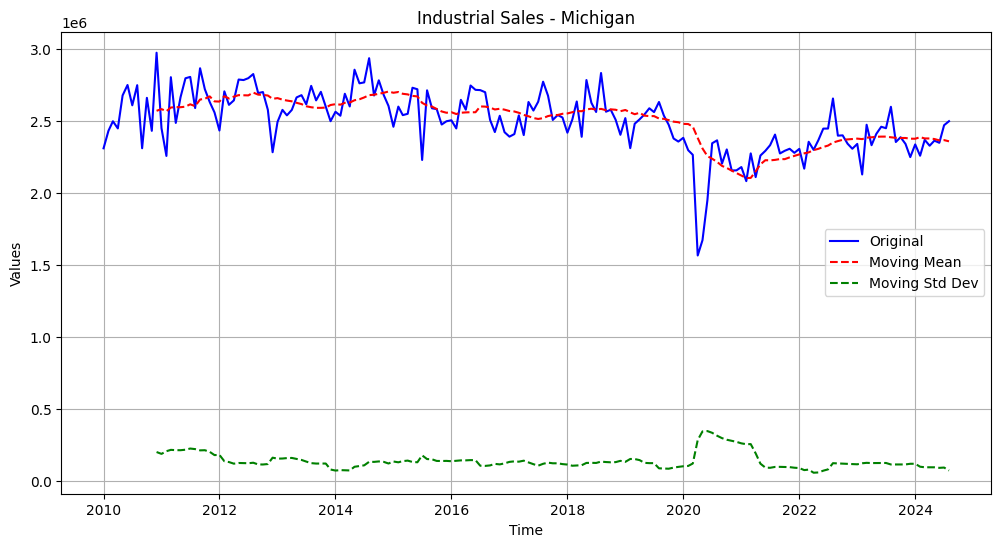

In [ ]:
plot_time_series(mi_industrial, column=industrial, title="Industrial Sales - Michigan")

In [ ]:
test_stationarity(mi_industrial, column=industrial)

Augmented Dickey-Fuller Test Results:
Test Statistic: -1.190914997643312
p-value: 0.6774915896301246
Lags Used: 11
Observations: 164

Conclusion: Time series is non-stationary.

KPSS Test Results:
Test Statistic: 1.250626272185605
p-value: 0.01
Lags Used: 8
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

KPSS Conclusion: Time series is non-stationary (variance).


In [ ]:
mi_seasonally_diff_industrial = seasonal_difference(mi_industrial[industrial], period=1)

In [ ]:
test_stationarity(mi_seasonally_diff_industrial, column=industrial)

Augmented Dickey-Fuller Test Results:
Test Statistic: -7.67201751327235
p-value: 1.5844144337336615e-11
Lags Used: 10
Observations: 164

Conclusion: Time series is stationary.

KPSS Test Results:
Test Statistic: 0.049946636180463876
p-value: 0.1
Lags Used: 6
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

KPSS Conclusion: Time series is stationary.


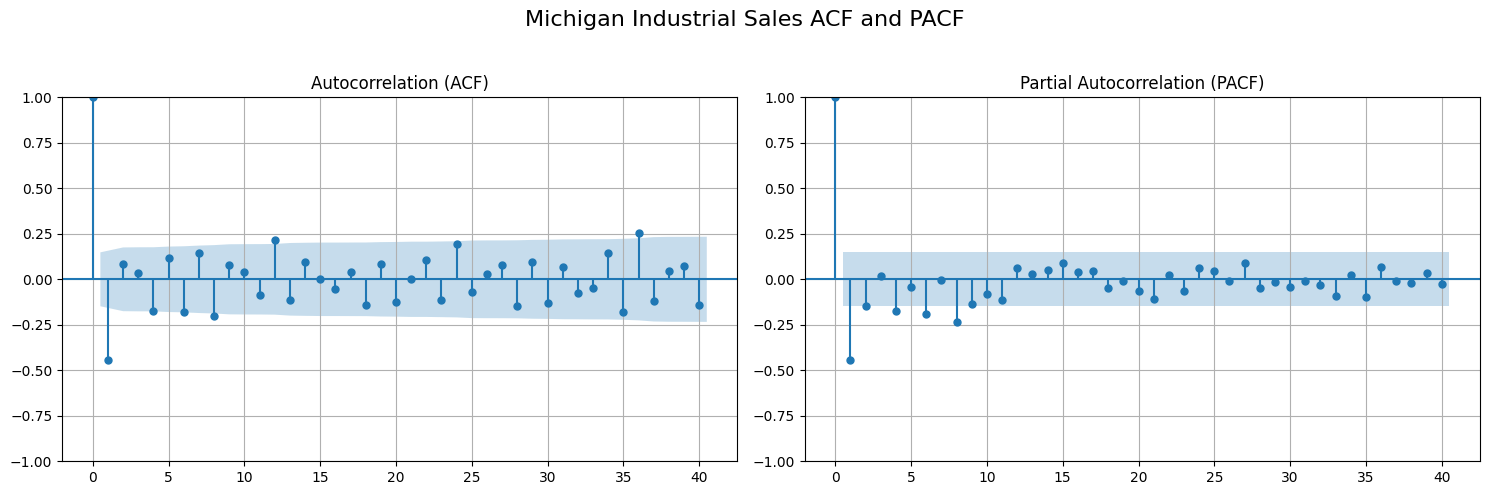

In [ ]:
plot_acf_pacf(mi_seasonally_diff_industrial[industrial], lags=40, title="Michigan Industrial Sales ACF and PACF")

In [ ]:
train_size_industrial = int(len(mi_seasonally_diff_industrial) * 0.8)
train_data_industrial = mi_seasonally_diff_industrial.iloc[:train_size_industrial][industrial]
test_data_industrial = mi_seasonally_diff_industrial.iloc[train_size_industrial:][industrial]

train_data_industrial = train_data_industrial.asfreq("MS")
test_data_industrial = test_data_industrial.asfreq("MS")

In [ ]:
p_range = (0, 8)
d_range = (0, 1)
q_range = (0, 8)

seasonal_params = {
    'P': (0, 2),
    'D': (0, 1),
    'Q': (0, 2),
    'S': 12
}

In [ ]:
results_industrial, best_arima_model_industrial, arima_forecast_industrial, arima_conf_int_industrial, best_sarima_model_industrial, sarima_forecast_industrial, sarima_conf_int_industrial = optimize_arima_sarima(
    train_data_industrial, test_data_industrial, p_range, d_range, q_range, True, seasonal_period=12, seasonal_params=seasonal_params)


Fitting ARIMA Model ...
ARIMA model fitted ...

Fitting SARIMA model ...
SARIMA model fitted ...


In [ ]:
results_industrial

{'ARIMA': {'RMSE': 121599.3830084835,
  'MAE': 89839.86745732045,
  'R2': -0.0039017276175283833},
 'SARIMA': {'RMSE': 89169.0114158186,
  'MAE': 67157.09499290324,
  'R2': 0.4601708122166823}}

In [ ]:
mi_industrial[industrial].describe()

,industrial_sales
count,1.760000e+02
mean,2.498105e+06
std,2.082034e+05
min,1.565122e+06
25%,2.361117e+06
50%,2.507026e+06
75%,2.642291e+06
max,2.973217e+06


In [ ]:
best_arima_model_industrial

ARIMA(order=(1, 0, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [ ]:
best_sarima_model_industrial

ARIMA(order=(1, 0, 1), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [ ]:
reversed_predictions_industrial, lower_conf_int_industrial, upper_conf_int_industrial = reverse_seasonal_differencing(
    original_series=mi_industrial[industrial].values,
    differenced_predictions=np.concatenate([train_data_industrial, sarima_forecast_industrial]),
    conf_int_lower=np.concatenate([train_data_industrial, sarima_conf_int_industrial[:, 0]]),
    conf_int_upper=np.concatenate([train_data_industrial, sarima_conf_int_industrial[:, 1]]),
    period=1
)

In [ ]:
actual_values_industrial = mi_industrial[industrial].values

In [ ]:
print(f"Length of original series = {len(actual_values_industrial)}")
print(f"Length of series w/ predictions = {len(reversed_predictions_industrial)}")
print(f"Length of series w/ lower confidence interval = {len(lower_conf_int_industrial)}")
print(f"Length of series w/ upper confidence interval = {len(upper_conf_int_industrial)}")

Length of original series = 176
Length of series w/ predictions = 188
Length of series w/ lower confidence interval = 188
Length of series w/ upper confidence interval = 188


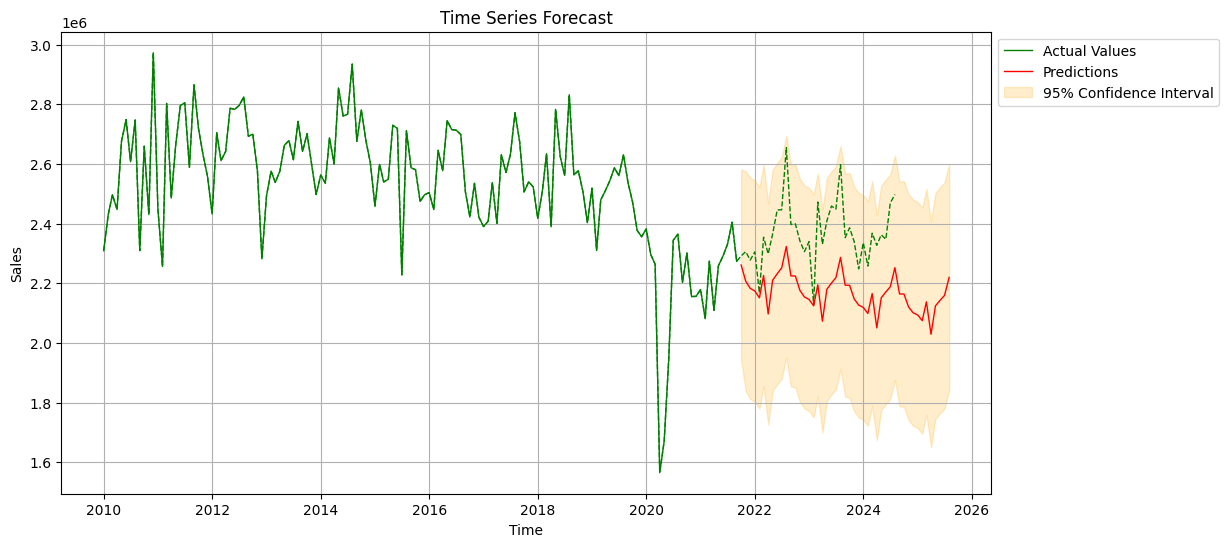

In [ ]:
plot_results(mi_industrial, industrial, actual_values_industrial, reversed_predictions_industrial, lower_conf_int_industrial, upper_conf_int_industrial, train_data_industrial, test_data_industrial, future_period=12)

In [ ]:
adjusted_predictions_mi_industrial, adjusted_lower_conf_int_industrial, adjusted_upper_conf_int_industrial = adjust_bias(test_data_industrial, sarima_forecast_industrial, sarima_conf_int_industrial[:, 0], sarima_conf_int_industrial[:, 1])

In [ ]:
reversed_predictions_industrial, lower_conf_int_industrial, upper_conf_int_industrial = reverse_seasonal_differencing(
    original_series=mi_industrial[industrial].values,
    differenced_predictions=np.concatenate([train_data_industrial, adjusted_predictions_mi_industrial]),
    conf_int_lower=np.concatenate([train_data_industrial, adjusted_lower_conf_int_industrial]),
    conf_int_upper=np.concatenate([train_data_industrial, adjusted_upper_conf_int_industrial]),
    period=1
)

In [ ]:
print(f"Length of original series = {len(actual_values_industrial)}")
print(f"Length of series w/ predictions = {len(reversed_predictions_industrial)}")
print(f"Length of series w/ lower confidence interval = {len(lower_conf_int_industrial)}")
print(f"Length of series w/ upper confidence interval = {len(upper_conf_int_industrial)}")

Length of original series = 176
Length of series w/ predictions = 188
Length of series w/ lower confidence interval = 188
Length of series w/ upper confidence interval = 188


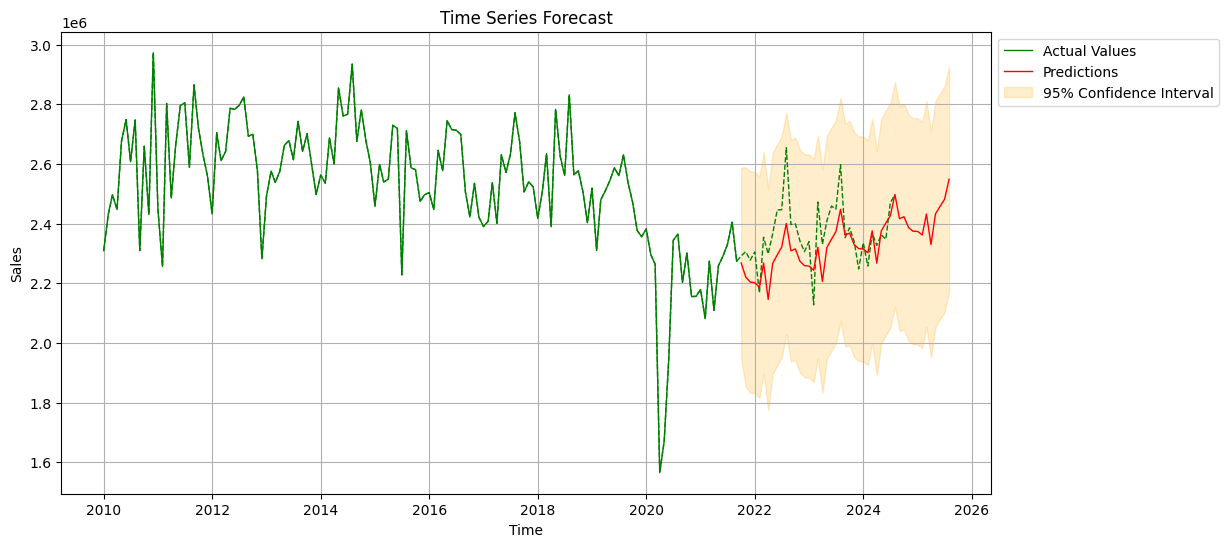

In [ ]:
plot_results(mi_industrial, industrial, actual_values_industrial, reversed_predictions_industrial, lower_conf_int_industrial, upper_conf_int_industrial, train_data_industrial, test_data_industrial, future_period=12)

In [ ]:
industrial_adjusted_rmse, industrial_adjusted_mae, industrial_adjusted_r2 = evaluate_model(actual_values_industrial, reversed_predictions_industrial[:-12])

print(f"RMSE: {industrial_adjusted_rmse}")
print(f"MAE: {industrial_adjusted_mae}")
print(f"R^2: {industrial_adjusted_r2}")

RMSE: 42152.8459759769
MAE: 15379.604148831299
R^2: 0.9587757651333877


In [ ]:
mi_industrial[industrial].describe()

,industrial_sales
count,1.760000e+02
mean,2.498105e+06
std,2.082034e+05
min,1.565122e+06
25%,2.361117e+06
50%,2.507026e+06
75%,2.642291e+06
max,2.973217e+06


**Analysis of Michigan's Industrial Sector:** <br>
The industrial sector's energy time series was confirmed as non-stationary through both the ADF and KPSS tests. First-order differencing made the series stationary, and an analysis of the ACF plot revealed minimal significant correlations, suggesting that a low-order ARIMA or SARIMA model would be optimal.

The SARIMA model (1, 0, 1)(1, 0, 1)[12] was initially selected, yielding an RMSE of 89,169, an MAE of 67,157, and an R² of 0.46. However, there was a noticeable bias between the model's predictions and the true values. After adjusting for this bias, performance metrics improved dramatically, with an RMSE of 42,152, an MAE of 15,379, and an R² of 0.958. Compared to the target column's standard deviation of 208,203, this represents a significant improvement.

The test data predictions reveal the model's ability to capture the sector's faint but complex seasonal trends, which involve a steep rise in consumption followed by a gradual tapering and a "double drop" pattern. Future forecasts indicate a continuation of these trends, with a double drop projected through the end of 2024, followed by increased consumption throughout 2025. This nuanced understanding of the sector's energy trends could help optimize energy production and storage, particularly during periods of increased demand or steep declines.

### Analysis: Michigan (Transportation Sector)

In [ ]:
transportation = "transportation_sales"
mi_transportation = df[df["state"] == "MI"]

mi_transportation.set_index("date", inplace=True)
mi_transportation = mi_transportation.sort_index(ascending=True)

In [ ]:
mi_transportation

,year,month,state,data_status,residential_revenue,residential_sales,residential_customers,residential_price,commercial_revenue,commercial_sales,...,industrial_customers,industrial_price,transportation_revenue,transportation_sales,transportation_customers,transportation_price,total_revenue,total_sales,total_customers,total_price
date,,,,,,,,,,,,,,,,,,,,,
2010-01-01,2010,1,MI,Final,374780.00,3281757.0,4247771.0,11.42,298599.00,3240851.0,...,12147.0,6.99,42.00,373.00,1.0,11.26,834925.0,8832476.0,4781495.0,9.45
2010-02-01,2010,2,MI,Final,312020.00,2697612.0,4247542.0,11.57,273810.00,2896480.0,...,12338.0,6.79,45.00,394.00,1.0,11.42,750838.0,8025787.0,4782728.0,9.36
2010-03-01,2010,3,MI,Final,320550.00,2712814.0,4247590.0,11.82,286711.00,2973960.0,...,13345.0,6.41,47.00,443.00,1.0,10.61,767317.0,8184398.0,4784419.0,9.38
2010-04-01,2010,4,MI,Final,280705.00,2203730.0,4246081.0,12.74,289985.00,2889711.0,...,12319.0,7.16,42.00,392.00,1.0,10.71,745976.0,7541365.0,4781331.0,9.89
2010-05-01,2010,5,MI,Final,326415.00,2549112.0,4245366.0,12.81,323912.00,3144752.0,...,12251.0,7.29,49.00,432.00,1.0,11.34,845397.0,8370852.0,4780847.0,10.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-01,2024,4,MI,Preliminary,432970.35,2251208.2,4529699.0,19.23,400723.10,2827688.4,...,5684.0,8.20,67.35,473.47,2.0,14.22,1024599.9,7406823.9,5098942.0,13.83
2024-05-01,2024,5,MI,Preliminary,481535.21,2477254.7,4531883.0,19.44,449325.16,3123397.1,...,5683.0,8.67,65.47,447.64,2.0,14.62,1135691.7,7963840.3,5102137.0,14.26
2024-06-01,2024,6,MI,Preliminary,629389.85,3165403.3,4530758.0,19.88,481623.42,3315461.2,...,5632.0,8.51,66.51,477.43,2.0,13.93,1310928.9,8829107.7,5100783.0,14.85


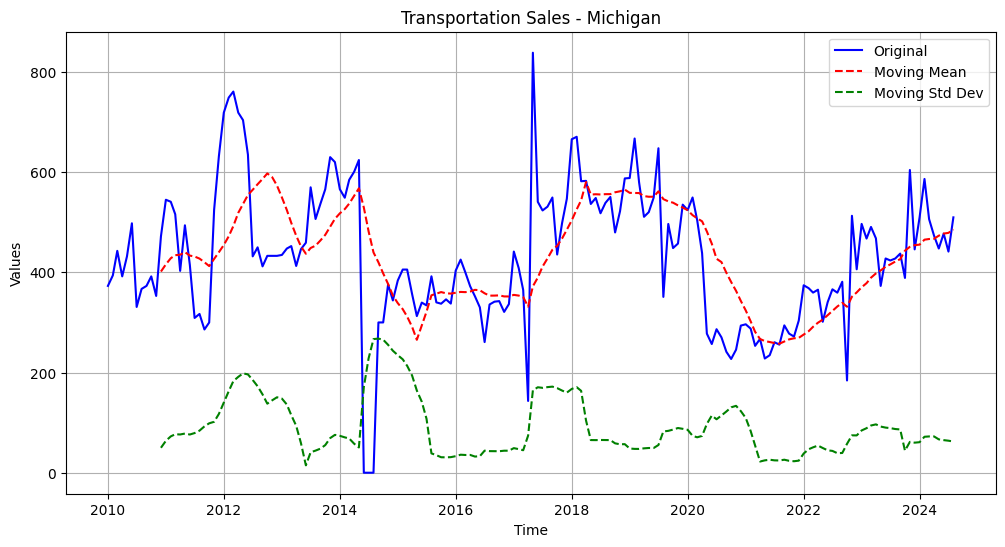

In [ ]:
plot_time_series(mi_transportation, column=transportation, title="Transportation Sales - Michigan")

In [ ]:
test_stationarity(mi_transportation, column=transportation)

Augmented Dickey-Fuller Test Results:
Test Statistic: -4.187135232015063
p-value: 0.000692729697480466
Lags Used: 1
Observations: 174

Conclusion: Time series is stationary.

KPSS Test Results:
Test Statistic: 0.13971951669494623
p-value: 0.1
Lags Used: 8
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

KPSS Conclusion: Time series is stationary.


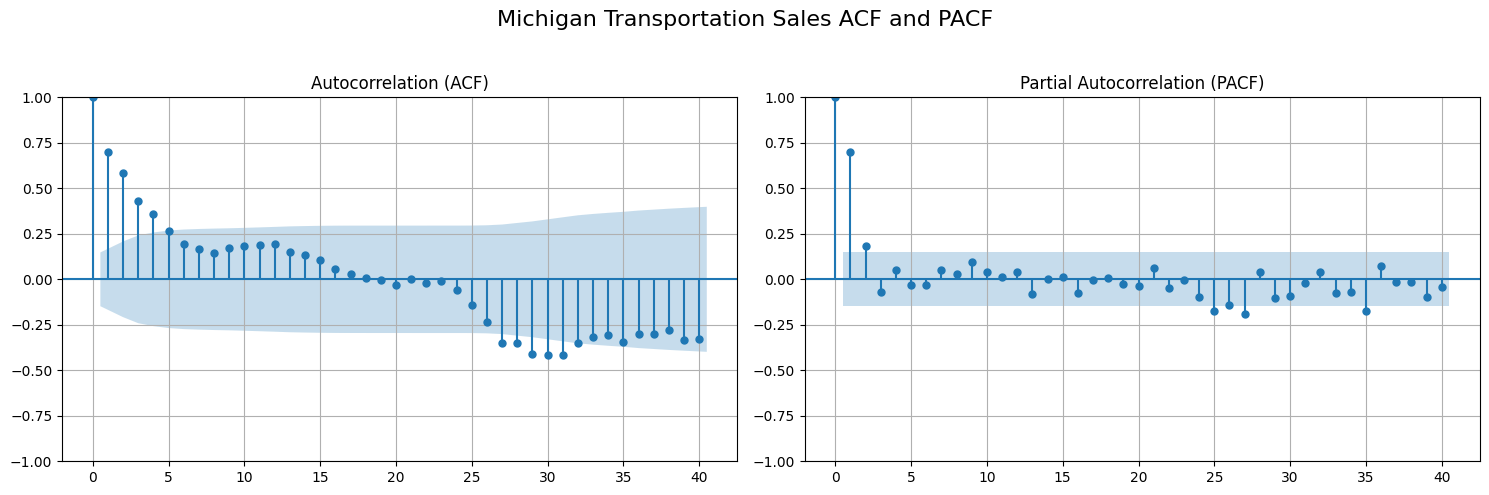

In [ ]:
plot_acf_pacf(mi_transportation[transportation], lags=40, title="Michigan Transportation Sales ACF and PACF")

In [ ]:
train_size_transportation = int(len(mi_transportation) * 0.8)
train_data_transportation = mi_transportation.iloc[:train_size_transportation][transportation]
test_data_transportation = mi_transportation.iloc[train_size_transportation:][transportation]

train_data_transportation = train_data_transportation.asfreq("MS")
test_data_transportation = test_data_transportation.asfreq("MS")

In [ ]:
p_range = (0, 6)
d_range = (0, 1)
q_range = (0, 6)

seasonal_params = {
    'P': (0, 2),
    'D': (0, 1),
    'Q': (0, 2),
    'S': 12
}

In [ ]:
results_transportation, best_arima_model_transportation, arima_forecast_transportation, arima_conf_int_transportation, best_sarima_model_transportation, sarima_forecast_transportation, sarima_conf_int_transportation = optimize_arima_sarima(
    train_data_transportation, test_data_transportation, p_range, d_range, q_range, True, seasonal_period=12, seasonal_params=seasonal_params)


Fitting ARIMA Model ...
ARIMA model fitted ...

Fitting SARIMA model ...
SARIMA model fitted ...


In [ ]:
results_transportation

{'ARIMA': {'RMSE': 74.72007939538801,
  'MAE': 55.457438553373365,
  'R2': 0.298372479599604},
 'SARIMA': {'RMSE': 74.72007939538801,
  'MAE': 55.457438553373365,
  'R2': 0.298372479599604}}

In [ ]:
mi_transportation[transportation].describe()

,transportation_sales
count,176.000000
mean,431.001932
std,136.784015
min,0.000000
25%,340.415000
50%,432.000000
75%,523.817500
max,838.560000


In [ ]:
best_arima_model_transportation

ARIMA(order=(2, 0, 0), scoring_args={}, suppress_warnings=True)

In [ ]:
best_sarima_model_transportation

ARIMA(order=(2, 0, 0), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True)

In [ ]:
lower_conf_int_transportation = pd.Series(
    arima_conf_int_transportation[:, 0], index=arima_forecast_transportation.index
)

upper_conf_int_transportation = pd.Series(
    arima_conf_int_transportation[:, 1], index=arima_forecast_transportation.index
)

In [ ]:
reversed_predictions_transportation = pd.concat([train_data_transportation, arima_forecast_transportation])
lower_conf_int_transportation = pd.concat([train_data_transportation, lower_conf_int_transportation])
upper_conf_int_transportation = pd.concat([train_data_transportation, upper_conf_int_transportation])

In [ ]:
actual_values_transportation = mi_transportation[transportation].values

In [ ]:
print(f"Length of original series = {len(actual_values_transportation)}")
print(f"Length of series w/ predictions = {len(reversed_predictions_transportation)}")
print(f"Length of series w/ lower confidence interval = {len(lower_conf_int_transportation)}")
print(f"Length of series w/ upper confidence interval = {len(upper_conf_int_transportation)}")

Length of original series = 176
Length of series w/ predictions = 188
Length of series w/ lower confidence interval = 188
Length of series w/ upper confidence interval = 188


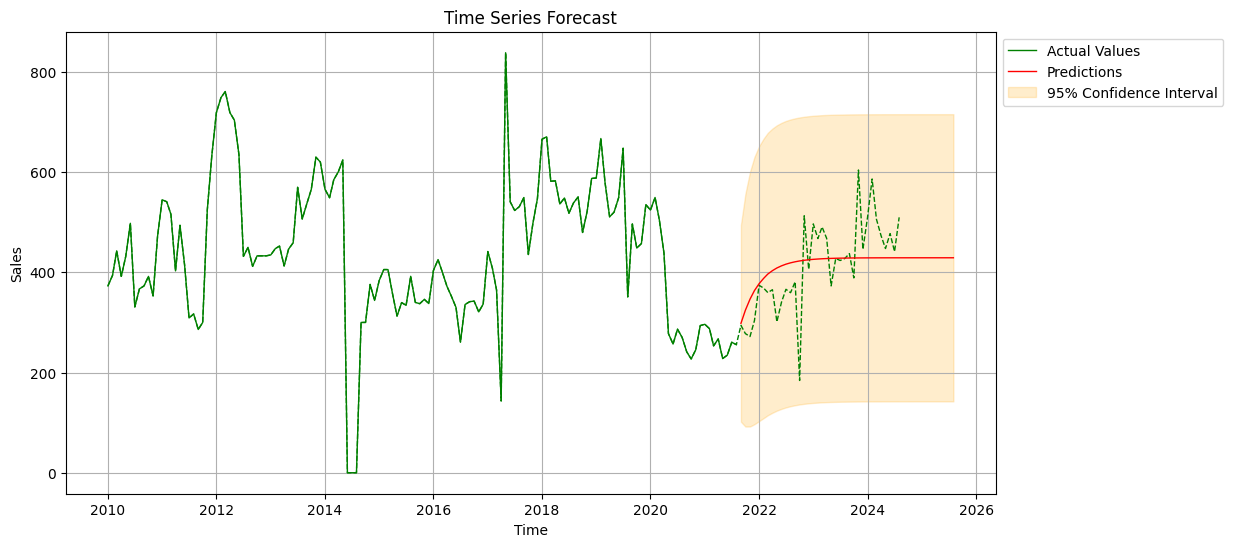

In [ ]:
plot_results(mi_transportation, transportation, actual_values_transportation, reversed_predictions_transportation, lower_conf_int_transportation, upper_conf_int_transportation, train_data_transportation, test_data_transportation, future_period=12)

**Analysis of Michigan's Transport Sector: <br>**
Although the transport sector's time series initially appeared non-stationary due to its scale, both the ADF and KPSS tests confirmed it was stationary. Unlike the other sectors, transport sales are significantly smaller in magnitude, which contributes to the appearance of volatility.

The ARIMA model (2, 0, 0) provided the best fit for this sector, with an RMSE of 74, an MAE of 55, and an R² of 0.29. While the RMSE indicates a good fit, the mediocre R² points to high variability in the data and a lack of discernible trends or patterns for the model to exploit. Predictions for the test data remained consistent around the mean of the erratic movements, unable to capture the sporadic fluctuations. However, given the lack of clear seasonal trends, the model's primary focus on prediction accuracy still represents a successful outcome.

Future forecasts for this sector suggest steady energy consumption without significant deviations. This could indicate limited growth or stagnation in the transport sector’s energy use. Unlike the other sectors, which exhibit strong seasonal patterns, the transport sector's randomness presents unique challenges and opportunities. Recommendations could focus on identifying external factors driving this steady usage and exploring ways to enhance efficiency in production and distribution systems tailored to this sector's needs.